In [2]:
import gzip
import pandas as pd
import numpy as np

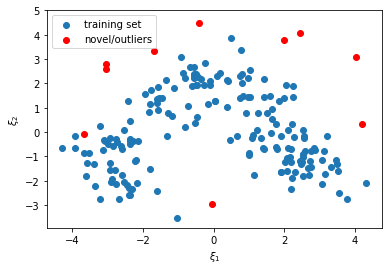

In [3]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pylab as plt

# load data set
data = load_wine()
X = data['data']

# truncate to two variables
pipe = Pipeline([('scaler', StandardScaler()), ('dim_red', PCA(n_components=2))])
Xt = pipe.fit_transform(X)

# generate novel/outlier points
np.random.seed(1)
theta = 2*np.pi*np.random.random(10)
X_test = np.vstack((4*np.cos(theta) + np.random.random(10), 4*np.sin(theta) + np.random.random(10)))

plt.scatter(*Xt.T)
plt.scatter(*X_test, c='red')
plt.xlabel('$\\xi_1$')
plt.ylabel('$\\xi_2$');
plt.legend(["training set", "novel/outliers"]);

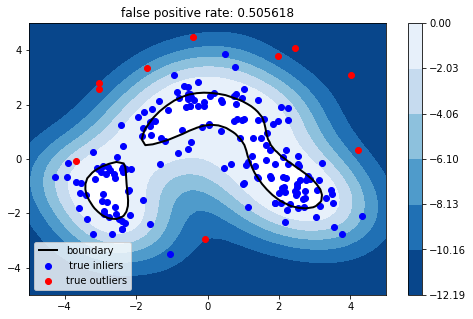

In [16]:
from sklearn.svm import OneClassSVM
from ipywidgets import interact, FloatSlider

def plot_one_class_svm(X, X_test):
    def plotter(nu=0.95):
        clf = OneClassSVM(nu=nu, gamma='auto')
        clf.fit(X)
        y_pred = clf.predict(X)
        fp_rate = (y_pred == -1).sum()/len(X)
        
        X1, X2 = np.meshgrid(np.linspace(-5, 5), np.linspace(-5, 5))
        y_proba = clf.decision_function(np.hstack((X1.reshape(-1, 1), X2.reshape(-1, 1))))
        Z = y_proba.reshape(50, 50)
        
        fig = plt.figure(figsize=(8, 5), facecolor='w', edgecolor='k')
        plt.contourf(X1, X2, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
        plt.colorbar()
        a = plt.contour(X1, X2, Z, levels=[0], linewidths=2, colors='black')            
        b1 = plt.scatter(*X.T, c='blue')
        b2 = plt.scatter(*X_test, c='red')
        plt.title("false positive rate: {:g}".format(fp_rate))
        plt.legend([a.collections[0], b1, b2], ["boundary", " true inliers", "true outliers"], frameon=True, 
                   loc="lower left")
    return plotter

nu_slider = FloatSlider(min=0.01, max=0.99, step=0.01, value=0.5, description='$\\nu$')
interact(plot_one_class_svm(Xt, X_test), nu=nu_slider);

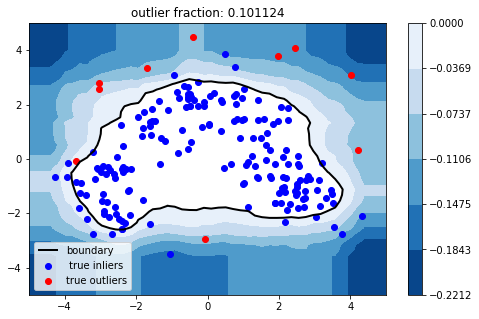

In [17]:
from sklearn.ensemble import IsolationForest

def plot_isolation_forest(X, X_test):
    def plotter(contamination=0.2):
        clf = IsolationForest(n_estimators=100, contamination=contamination, behaviour='new')
        clf.fit(X,y)
    
        y_pred = clf.predict(X)
        outlier_rate = (y_pred == -1).sum()/len(X)
        
        X1, X2 = np.meshgrid(np.linspace(-5, 5), np.linspace(-5, 5))
        y_proba = clf.decision_function(np.hstack((X1.reshape(-1, 1), X2.reshape(-1, 1))))
        Z = y_proba.reshape(50, 50)
        
        fig = plt.figure(figsize=(8, 5), facecolor='w', edgecolor='k')
        plt.contourf(X1, X2, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
        plt.colorbar()
        a = plt.contour(X1, X2, Z, levels=[0], linewidths=2, colors='black')            
        b1 = plt.scatter(*X.T, c='blue')
        b2 = plt.scatter(*X_test, c='red')
        plt.title("outlier fraction: {:g}".format(outlier_rate))
        plt.legend([a.collections[0], b1, b2], ["boundary", " true inliers", "true outliers"], frameon=True, 
                   loc="lower left")    
    return plotter

cont_slider = FloatSlider(min=0.01, max=0.5, value=0.1, step=0.01, description="fraction")
interact(plot_isolation_forest(Xt, X_test), contamination=cont_slider);

In [247]:
from sklearn.datasets import load_iris
X,y = load_iris(return_X_y = True)

In [106]:
X,y = load_wine(return_X_y=True)

In [42]:
class AnomalyDetection:
    ''' The class initialization.'''
    def __init__(self,epsilon =2e-2): 
        self.epsilon = epsilon
    
    def fit_parameters(self, X):
        
        ''' Fitting the parameters to help
        in the calculation of the anomaly detection 
        probability'''
        
        self.means = []
        self.variances = []
        for j in range(X.shape[1]):
            m = X[:,j].mean()
            self.means.append(m)
            
            var = np.sum((X[:,j] - m)**2)/len(X[:,j])
            self.variances.append(var)            
            
        return self
    
    def multiply(self,X):
        array = [self._predict(x) for x in X]
        z = []
        for arr in array: 
            pro = np.product(arr) 
            z.append(pro)
        return z    
    
    def predict(self,X):
        ''' Classifying whether an observation is an inlier or an outlier'''
        
        return np.array([-1 if x < self.epsilon else 1 for x in self.multiply(X)])
    
    def _predict(self,x):
        
        const_j = 1/(np.sqrt(2*np.pi * np.array(self.variances)))
        pw_j = -(x - self.means)/(2*np.array(self.variances))
        prob_j = np.exp(pw_j)
        prob = const_j * prob_j
        
        return prob    
        
    

In [98]:
ad = AnomalyDetection(epsilon=3e-10)

In [99]:
ad.fit_parameters(X)

In [102]:
frate = (ad.predict(X) == -1).sum()

In [103]:
ad.predict(X)

array([ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1, -1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1])

In [105]:
frate/len(X)

0.10112359550561797

In [111]:
# Using sklearn algorithm for outlier detection
clf = IsolationForest(contamination=0.10)
clf.fit(X)
y_pred = clf.predict(X)
fp_rate = (y_pred == -1).sum()/len(X)

In [112]:
fp_rate

0.10112359550561797